In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/TSOAI/S6")

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
#from model import Net
from model import Train,NetBatchNorm
from utils import display_model_summary
import numpy as np
import torchvision

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.Resize((32,32)),
                                       transforms.RandomRotation((-7.0, 7.0)),
                                       transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                       transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.

                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                                       ])

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 48854216.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [41]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert_numpy(image):
  #image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
batch_size=4

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


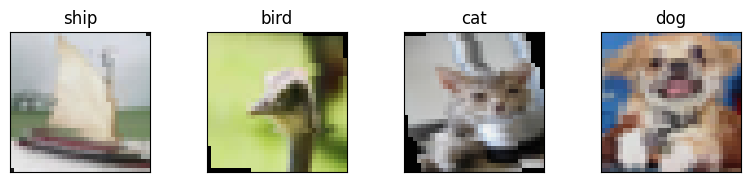

In [9]:
# We iter the batch of images to display
dataiter = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(dataiter) #going from 1st batch of 100 images to the next batch
#print(images[0].shape)
fig = plt.figure(figsize=(25, 4))

# We plot 4 images from our train_dataset
for idx in np.arange(4):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# instantiate the model and load it to the device
model = NetBatchNorm().to(device)
#model
display_model_summary(model,input_structure=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]             540
              ReLU-2           [-1, 20, 32, 32]               0
       BatchNorm2d-3           [-1, 20, 32, 32]              40
            Conv2d-4           [-1, 20, 32, 32]           3,600
              ReLU-5           [-1, 20, 32, 32]               0
       BatchNorm2d-6           [-1, 20, 32, 32]              40
            Conv2d-7           [-1, 20, 32, 32]           3,600
              ReLU-8           [-1, 20, 32, 32]               0
           Dropout-9           [-1, 20, 32, 32]               0
      BatchNorm2d-10           [-1, 20, 32, 32]              40
           Conv2d-11           [-1, 32, 32, 32]             640
             ReLU-12           [-1, 32, 32, 32]               0
          Dropout-13           [-1, 32, 32, 32]               0
      BatchNorm2d-14           [-1

In [11]:
# set up the optimizer with model parameters , learning rate and momentum
optimizer = optim.SGD(model.parameters(),lr=0.1, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.01, steps_per_epoch=len(train_loader), epochs=11)
criterion = nn.CrossEntropyLoss()

In [12]:
train_instance = Train(model,device,criterion,optimizer,scheduler,train_loader,test_loader,num_epochs=11)

In [13]:
train_instance()

epoch : 1
training loss: 0.4381, acc 35.22% 
validation loss: 0.3607, validation acc 47.00% 
epoch : 2
training loss: 0.3522, acc 48.86% 
validation loss: 0.3116, validation acc 54.54% 
epoch : 3
training loss: 0.3181, acc 54.04% 
validation loss: 0.2810, validation acc 59.75% 
epoch : 4
training loss: 0.2950, acc 57.70% 
validation loss: 0.2706, validation acc 60.35% 
epoch : 5
training loss: 0.2796, acc 59.88% 
validation loss: 0.2531, validation acc 63.60% 
epoch : 6
training loss: 0.2660, acc 62.14% 
validation loss: 0.2335, validation acc 66.81% 
epoch : 7
training loss: 0.2529, acc 64.29% 
validation loss: 0.2442, validation acc 66.06% 
epoch : 8
training loss: 0.2394, acc 66.16% 
validation loss: 0.2275, validation acc 68.96% 
epoch : 9
training loss: 0.2272, acc 68.03% 
validation loss: 0.2060, validation acc 71.12% 
epoch : 10
training loss: 0.2132, acc 69.91% 
validation loss: 0.2040, validation acc 71.29% 
epoch : 11
training loss: 0.2039, acc 71.31% 
validation loss: 0.1946

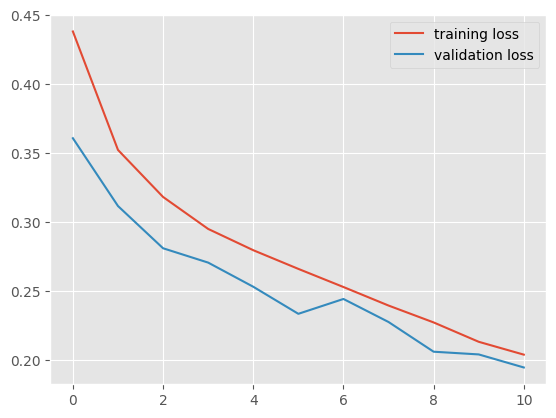

In [16]:
plt.style.use('ggplot')
plt.plot(train_instance.running_loss_history, label='training loss')
plt.plot(train_instance.val_running_loss_history, label='validation loss')
plt.legend()

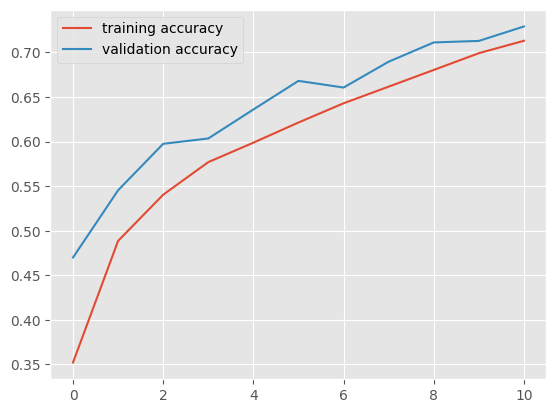

In [17]:
plt.style.use('ggplot')
plt.plot([i.cpu().detach().numpy() for i in train_instance.running_corrects_history], label='training accuracy')
plt.plot([i.cpu().detach().numpy() for i in train_instance.val_running_corrects_history], label='validation accuracy')
plt.legend()

In [58]:
def find_misclassified_images(num_of_images,test_loader,device,model):
  count = 0
  fig = plt.figure(figsize=(25, 4))
  # Evaluate the model on the test dataset
  misclassified_images = []
  misclassified_labels = []
  true_labels = []
  ## Collect 15 miss-classified images
  while (count < num_of_images):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    _, preds = torch.max(output, 1)
    for idx in range(4):
      if preds[idx] !=labels[idx] and count < 15:
        count +=1
        misclassified_images.append(images[idx].cpu().detach().numpy())
        misclassified_labels.append(preds[idx].cpu().detach().numpy())
        true_labels.append(labels[idx].cpu().detach().numpy())
      else:
        break
  return misclassified_images,misclassified_labels,true_labels

In [59]:
misclassified_images,misclassified_labels,true_labels=find_misclassified_images(15,test_loader,device,model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<Figure size 2500x400 with 0 Axes>

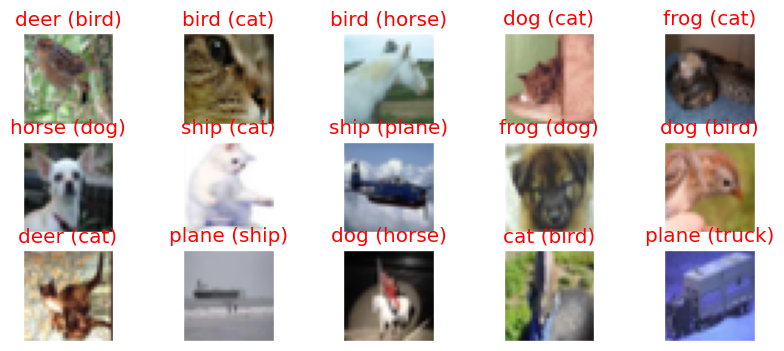

In [60]:
#### Displaying those images
fig = plt.figure(figsize=(10, 4))
for idx in range(len(misclassified_images)):
    ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert_numpy(misclassified_images[idx]))
    ax.set_title("{} ({})".format(str(classes[misclassified_labels[idx]]), str(classes[true_labels[idx]])), color=("red"))